# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement HMC

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

# Stochastic Gradient HMC with Naive Approach

The Naive approach refers to the simple plug-in estimator of $\triangledown \tilde{U}(\theta) = -\frac{|D|}{|\tilde{D}|}\sum_{x \in \tilde{D}} \triangledown log p(x|\theta) - \triangledown log p(\theta)$ with minibatch $\tilde{D}$. $\triangledown \tilde{U}(\theta)$ is computationally easier, but then the resulting joint distribution $\pi(\theta, r)$ is not invariant.

The Hamiltonian Dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt + N(0,2B(\theta)) dt$$
where $B(\theta) = \frac{1}{2}\epsilon V(\theta)$

# need to find covariance of the stochastic gradient noise

Since $\epsilon$ is small, it does not really matter that V is. Thus we take V as identity.

### Implement Naive SGHMC

# SGHMC with Friction

Add friction term to momentum update:
$$
d\theta = M^{-1}r dt\\
dr = - \triangledown U(\theta)dt - BM^{-1}rdt+N(0,2Bdt)
$$

# new proposal for SGHMC with friction

In [1]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
from ipyparallel import Client

In [ ]:
btheta1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

In [33]:
def SGHMC_friction(theta0, X, grad_logden_data, grad_logden_prior, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction. See details from Stochastic Gradient Hamiltonian Monte Carlo (Chen et al., 2014)
    
    INPUT:
    ----------------------------------------------------------------------
    theta0(numpy array of shape(p,)): starting position of theta
    
    X(numpy array of shape(n,m)): data
    
    grad_logden_data: gradient of the data log density
    
    grad_logden_prior: gradient of the prior log density
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm-up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    i = sample_size+burnin
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            sumg = 0
            for x in batch[j]:
                sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
            gU = - X.shape[0]/batch[j].shape[0]* sumg
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(n), np.array(2*eps*(C-B)).reshape(n,n)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,],rt[burnin+1:,:]
        

In [34]:
def SGHMC_friction3(theta0, X, grad_logden_data, grad_logden_prior, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    sample_size: number of samples drawn from prosterior distribution
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    i = sample_size + burnin
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
        
    Msqrt = np.linalg.cholesky(2*eps*(C-B))
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            sumg = 0
            for x in batch[j]:
                sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
            gU = - X.shape[0]/batch[j].shape[0]* sumg
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri +  Msqrt@np.random.normal(size=n).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,],rt[burnin+1:,:]

In [29]:
def SGHMC_parallel(theta0, X, grad_logden_data, grad_logden_prior, eps, sample_size, B, C, batch_size,burnin, M = None):
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    i = int((sample_size+n*burnin)/4)
    
    @dv.remote(block=True)
    def SGHMC_friction4(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size,burnin, M = None):
        '''
        SGHMC with friction:
        theta0(numpy array): starting position of theta
        X: data
        grad_logden_data: gradient of the data log density
        grad_logden_prior: gradient of the prior log density
        eps: step size
        i: number of iterations
        B: noise estimate
        C: user specified friction term
        batch_size: size of minibatches
        M: Mass matrix
        '''

        n = theta0.shape[0]
        rt = numpy.zeros((i+1,n))
        thetat = numpy.zeros((i+1,n))
        thetat[0,:] = theta0

        m1 = int(numpy.ceil(X.shape[0]/batch_size))
        batch = [X[i::m1] for i in range(m1)]
        m = len(batch)

        if(M is None):
            M = numpy.eye(n)

        Msqrt = numpy.linalg.cholesky(2*eps*(C-B))

        for t in range(i):
            rt[t,:] = numpy.random.multivariate_normal(numpy.zeros(n), M)
            theta0,r0 = thetat[t,:],rt[t,:]
            thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
            for j in range(m):
                thetai = thetai + eps * numpy.linalg.inv(M) @ ri
                sumg = 0
                for x in batch[j]:
                    sumg += grad_logden_data(x,thetai)-grad_logden_prior(thetai)
                gU = - X.shape[0]/batch[j].shape[0]* sumg
                ri = ri - eps * gU.reshape(-1,1) - eps * C @ numpy.linalg.inv(M) @ ri + (Msqrt@numpy.random.normal(size=n)).reshape(-1,1)
            thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)

        return thetat[burnin+1:,]
    
    theta = SGHMC_friction4(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size,burnin, M)
    return numpy.concatenate(theta)

In [30]:
def grad_logden_data(x,theta):
    return -(-4*theta+4*theta**3)/50

In [31]:
def grad_prior(theta):
    return 0

In [ ]:
rc = Client()
dv = rc[:]
with dv.sync_imports():
    import numpy

In [32]:
%%time
theta1 = SGHMC_parallel(np.array([0]),np.zeros((50,1)),grad_logden_data,grad_prior,0.1,2000, np.array([0]),2*np.eye(1),10,500)

TypeError: can't pickle module objects

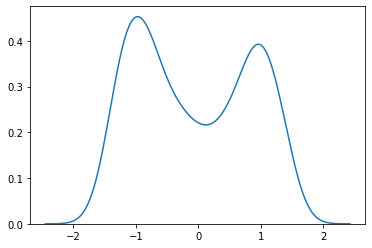

In [28]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

In [13]:
import random

In [19]:
%%time
random.seed(100)
theta1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 4.7 s


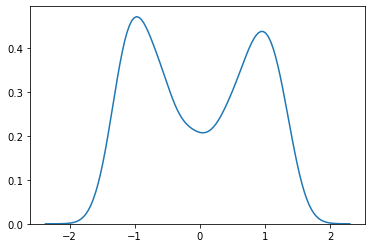

In [24]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

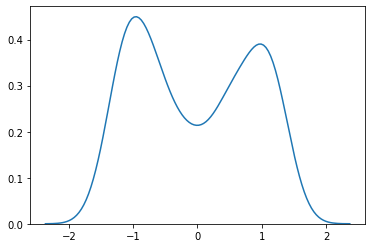

In [107]:
sns.kdeplot(theta1.reshape(-1,))

In [173]:
%%time
random.seed(100)
theta,r = SGHMC_friction3(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                eps=0.1,i=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 2.19 s, sys: 12 ms, total: 2.2 s
Wall time: 2.19 s


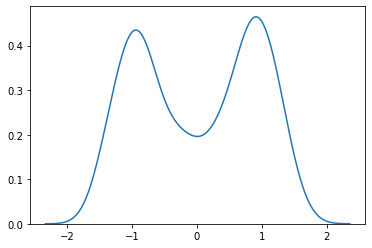

In [174]:
sns.kdeplot(theta.reshape(-1,))

In [19]:
mu = np.array([-5, 5]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [46]:
def mn_glpdf(y,mu):
    exp1=numpy.exp(-0.5*(y-mu[0])**2)
    exp2=numpy.exp(-0.5*(y-mu[1])**2)
    
    v = numpy.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
    return numpy.sum(v/(exp1+exp2),axis=0)

def mn_glpr(mu):
    return -(numpy.sum(mu)/100)

In [64]:
X = np.arange(50)
m1 = int(numpy.ceil(X.shape[0]/10))
batch = [X[i::m1] for i in range(m1)]
y= batch[0]
mu = np.array([10,10])

In [65]:
exp1=numpy.exp(-0.5*(y-mu[0])**2)
exp2=numpy.exp(-0.5*(y-mu[1])**2)


In [66]:
exp1,exp2

(array([1.92874985e-022, 3.72665317e-006, 1.00000000e+000, 3.72665317e-006,
        1.92874985e-022, 1.38634329e-049, 1.38389653e-087, 1.91855567e-136,
        3.69388307e-196, 9.87710872e-267]),
 array([1.92874985e-022, 3.72665317e-006, 1.00000000e+000, 3.72665317e-006,
        1.92874985e-022, 1.38634329e-049, 1.38389653e-087, 1.91855567e-136,
        3.69388307e-196, 9.87710872e-267]))

In [67]:
v = numpy.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]

In [68]:
v

array([[-1.92874985e-021, -1.92874985e-021],
       [-1.86332659e-005, -1.86332659e-005],
       [ 0.00000000e+000,  0.00000000e+000],
       [ 1.86332659e-005,  1.86332659e-005],
       [ 1.92874985e-021,  1.92874985e-021],
       [ 2.07951494e-048,  2.07951494e-048],
       [ 2.76779305e-086,  2.76779305e-086],
       [ 4.79638917e-135,  4.79638917e-135],
       [ 1.10816492e-194,  1.10816492e-194],
       [ 3.45698805e-265,  3.45698805e-265]])

In [69]:
v/(exp1+exp2)[:,None]

array([[-5. , -5. ],
       [-2.5, -2.5],
       [ 0. ,  0. ],
       [ 2.5,  2.5],
       [ 5. ,  5. ],
       [ 7.5,  7.5],
       [10. , 10. ],
       [12.5, 12.5],
       [15. , 15. ],
       [17.5, 17.5]])

In [70]:
numpy.sum(v/(exp1+exp2)[:,None],axis=0)

array([62.5, 62.5])

In [49]:
mn_glpdf(batch[0],np.array([1,1]))

ValueError: operands could not be broadcast together with shapes (10,2) (10,) 

In [31]:
%%time
theta_mn,r_mn = SGHMC_friction2(theta0=np.array([1,1]), X = y[:,None], grad_logden_data=mn_glpdf, grad_logden_prior=mn_glpr, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

CPU times: user 1min 5s, sys: 39.2 s, total: 1min 45s
Wall time: 52.5 s


In [32]:
%%time
theta = SGHMC_parallel(theta0=np.array([1,1]), X = y[:,None], grad_logden_data=mn_glpdf, grad_logden_prior=mn_glpr, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

CPU times: user 104 ms, sys: 132 ms, total: 236 ms
Wall time: 48.6 s


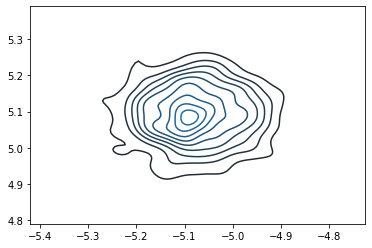

In [22]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## take simulated data from normal distribution as example

Simulate 1000 samples from N($\mu=10$,100). We want to sample $\mu$ from the posterior $p(\mu|D)$.

In [17]:
x = np.random.normal(10,10,1000)
x

array([ 17.80940264, -12.90820253,   7.28730158,  11.06798918,
        11.60151888,  11.52779961,  13.94589599,   6.89335457,
         3.16399043,   8.40223896,  13.50102312,  -1.40375701,
        19.15975341,   4.18365302,  17.96333108,  24.49682133,
        22.0669001 ,  28.21241096,  13.91144207,  12.41888075,
        27.3721917 ,  12.00762573,  22.81031273,  -1.66883626,
        14.16268348,  10.31081083,   3.37091621,   1.85686351,
         9.12526968,   1.23114633,   8.73409384,  12.12821401,
        21.82392889,  -1.67923164,   7.77180986,  28.60366585,
         3.398824  ,  11.904201  ,  12.57085559,  -1.29833357,
         0.76868049,   6.0881222 ,  20.58094711,  13.86919508,
        18.89686745,   8.20342771,  11.93477613,  27.14852621,
         2.67665932,  17.02110929,  21.18588254,   3.9019094 ,
        19.22471588,  19.99143714,   8.89151477,  10.780995  ,
        23.25832844,  19.99770292,  24.17510603,  -1.59341681,
        -2.83259822,  14.63235251, -12.78731209,  16.17

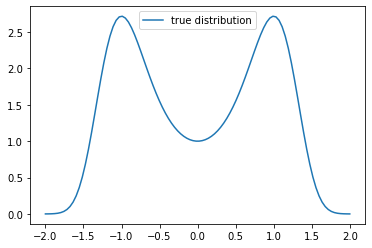

In [30]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")

array([[1., 0.],
       [0., 1.]])